## 1. Load Data and read files

In [53]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

DATA_DIR = r"C:\Users\atrey\OneDrive\Sem2\Courses\CS256-TopicsAI\CS256-AISoloProject\MMash-data-exploration\mmash\mmash\MMASH\DataPaper"

activity_labels = {
    0: "Unknown",
    1: "Sleeping",
    2: "Lying down",
    3: "Sitting",
    4: "Light movement",
    5: "Medium movement",
    6: "Heavy movement",
    7: "Eating",
    8: "Small screen usage",
    9: "Large screen usage",
    10: "Caffeinated drinks",
    11: "Smoking",
    12: "Alcohol consumption"
}

def load_data(user_id):
    """
    Reads Activity.csv and Actigraph.csv for a single user.
    Returns two dataframes: df_acti, df_actig
    """
    user_folder = os.path.join(DATA_DIR, f"user_{user_id}")
    activity_file = os.path.join(user_folder, "Activity.csv")
    actigraph_file = os.path.join(user_folder, "Actigraph.csv")

    df_acti = pd.read_csv(activity_file)
    df_actig = pd.read_csv(actigraph_file)
    return df_acti, df_actig

# Example: load for a single user
df_acti_1, df_actig_1 = load_data(1)


## 2. Data Preprocessing

Take care of time formats

In [54]:
# Convert Times and Label Each Second
def parse_times(df_acti, df_actig):
    """
    Create new datetime columns in both dataframes.
    """
    # Convert Day + "HH:MM" -> datetime
    def make_datetime_activity(day_number, hhmm_str, base_date=datetime.date(2025,1,1)):
        day_offset = datetime.timedelta(days=int(day_number) - 1)
        if hhmm_str == "24:00":
            # Roll over to next day at 00:00
            day_offset += datetime.timedelta(days=1)
            hhmm_str = "00:00"
        t = datetime.datetime.strptime(hhmm_str, "%H:%M").time()
        return datetime.datetime.combine(base_date + day_offset, t)

    df_acti = df_acti.dropna(subset=["Start", "End"]).copy()
    df_acti["Start_dt"] = df_acti.apply(
        lambda row: make_datetime_activity(row["Day"], row["Start"]), axis=1
    )
    df_acti["End_dt"] = df_acti.apply(
        lambda row: make_datetime_activity(row["Day"], row["End"]), axis=1
    )

    # Convert day + "HH:MM:SS" -> datetime
    def make_datetime_actigraph(day_number, hhmmss_str, base_date=datetime.date(2025,1,1)):
        day_offset = datetime.timedelta(days=int(day_number) - 1)
        t = datetime.datetime.strptime(hhmmss_str, "%H:%M:%S").time()
        return datetime.datetime.combine(base_date + day_offset, t)

    df_actig = df_actig.copy()
    df_actig["Datetime"] = df_actig.apply(
        lambda row: make_datetime_actigraph(row["day"], row["time"]), axis=1
    )

    return df_acti, df_actig


Handling missing values

In [55]:
# clean dataframes
def clean_df_acti(df_acti):
    """
    Clean the dataframes by removing unnecessary columns and renaming them.
    """
    # Remove unnecessary columns
    #df_acti = df_acti.drop(columns=["Day", "Start", "End"])
    #df_actig = df_actig.drop(columns=["day", "time"])

    # Rename columns for clarity
    #df_acti = df_acti.rename(columns={"Start_dt": "Start", "End_dt": "End"})
    #df_actig = df_actig.rename(columns={"Datetime": "Time"})
    df_acti = df_acti.dropna(subset=["Start", "End", "Activity"])
    df_acti = df_acti.dropna()
    df_acti = df_acti[df_acti["End_dt"] >= df_acti["Start_dt"]]


    return df_acti

def clean_df_actig(df_actig):
    """
    Clean the dataframes by removing unnecessary columns and renaming them.
    """
    # Remove unnecessary columns
    #df_acti = df_acti.drop(columns=["Day", "Start", "End"])
    #df_actig = df_actig.drop(columns=["day", "time"])

    # Rename columns for clarity
    #df_acti = df_acti.rename(columns={"Start_dt": "Start", "End_dt": "End"})
    #df_actig = df_actig.rename(columns={"Datetime": "Time"})
    df_actig = df_actig.dropna(subset=["day", "time"])
    df_actig = df_actig.dropna()
    
    return df_actig

Interpolation, Noise reduction, Normalization

In [56]:
# Butterworth Filter Function for noise removal
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=2.5, fs=50.0, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def preprocess_user_raw(user_id):
    """
    Preprocess raw actigraph data for a user:
    - Load data
    - Parse datetime columns
    - Interpolate missing sensor values
    """
    df_acti, df_actig = load_data(user_id)
    df_acti, df_actig = parse_times(df_acti, df_actig)
    df_acti = clean_df_acti(df_acti)
    df_actig = clean_df_actig(df_actig)
    
    # Interpolate missing sensor values
    sensor_cols = ["Axis1", "Axis2", "Axis3"]
    df_actig[sensor_cols] = df_actig[sensor_cols].interpolate(method='linear', limit_direction='both')

    # Noise reduction using Butterworth filter
    for col in sensor_cols:
        df_actig[col] = butter_lowpass_filter(df_actig[col].values)

    # Z-score normalization
    df_actig[sensor_cols] = (df_actig[sensor_cols] - df_actig[sensor_cols].mean()) / df_actig[sensor_cols].std()

    return df_acti, df_actig


Data segmentation

In [57]:
def segment_timeseries(df_actig, sensor_cols=["Axis1", "Axis2", "Axis3"], 
                       window_size=50, step_size=25):
    """
    Segment time-series data into overlapping windows.
    
    Returns a list of (window_matrix, start_time) tuples.
    """
    segments = []
    timestamps = []

    for start in range(0, len(df_actig) - window_size + 1, step_size):
        end = start + window_size
        segment = df_actig[sensor_cols].iloc[start:end].values
        segments.append(segment)
        timestamps.append(df_actig["Datetime"].iloc[start])  # For potential label alignment

    return segments, timestamps

all_user_segments = {}

for user_id in range(1, 23):
    try:
        df_acti, df_actig = preprocess_user_raw(user_id)
        segments, timestamps = segment_timeseries(df_actig)
        all_user_segments[user_id] = segments  # store just segments, or also timestamps if needed
    except FileNotFoundError:
        print(f"User {user_id} data missing, skipping.")


## 3. Feature Engineering

Time-domain feature extraction 

In [58]:
# Time-Domain Feature Extraction Function
from scipy.stats import skew, kurtosis
import numpy as np

def extract_time_domain_features(segment):
    """
    Extract time-domain features from a window of shape (window_size, num_channels).
    Returns a flat feature vector.
    """
    features = []

    # For each axis (e.g., Axis1, Axis2, Axis3)
    for i in range(segment.shape[1]):
        axis_data = segment[:, i]
        features.append(np.mean(axis_data))
        features.append(np.std(axis_data))
        features.append(np.min(axis_data))
        features.append(np.max(axis_data))
        features.append(np.ptp(axis_data))  # Peak-to-peak
        features.append(skew(axis_data))
        features.append(kurtosis(axis_data))
        features.append(np.sum(np.abs(axis_data)))  # Signal magnitude area

    return features

# Apply to all user
all_user_features = {}

for user_id, segments in all_user_segments.items():
    user_features = [extract_time_domain_features(seg) for seg in segments]
    all_user_features[user_id] = user_features

C:\Users\atrey\AppData\Local\Temp\ipykernel_29612\928237967.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(skew(axis_data))
C:\Users\atrey\AppData\Local\Temp\ipykernel_29612\928237967.py:21: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(kurtosis(axis_data))


Frequency-domain feature extraction

In [59]:
# FFT based feature extraction function
from scipy.fft import fft

def extract_frequency_domain_features(segment, fs=50):
    """
    Extract frequency-domain features from a window using FFT.
    """
    features = []
    N = segment.shape[0]  # window size

    for i in range(segment.shape[1]):
        axis_data = segment[:, i]
        freqs = fft(axis_data)
        magnitudes = np.abs(freqs)[:N // 2]  # Keep positive frequencies

        # Dominant frequency (index of max magnitude)
        dominant_freq_idx = np.argmax(magnitudes)
        dominant_magnitude = magnitudes[dominant_freq_idx]
        features.append(dominant_freq_idx * fs / N)  # Convert index to frequency
        features.append(dominant_magnitude)

        # Energy = sum of squared magnitudes
        energy = np.sum(magnitudes ** 2)
        features.append(energy)

    return features

# Combine Time + Frequency Features
def extract_features(segment):
    return extract_time_domain_features(segment) + extract_frequency_domain_features(segment)

# Apply to all user
all_user_features = {}

for user_id, segments in all_user_segments.items():
    user_features = [extract_features(seg) for seg in segments]
    all_user_features[user_id] = user_features

C:\Users\atrey\AppData\Local\Temp\ipykernel_29612\928237967.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(skew(axis_data))
C:\Users\atrey\AppData\Local\Temp\ipykernel_29612\928237967.py:21: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(kurtosis(axis_data))


Feature selection

In [63]:
# Tree based feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

def select_features_tree_based(X, y, threshold="median"):
    """
    Use Random Forest feature importance to select top features.
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    selector = SelectFromModel(rf, threshold=threshold, prefit=True)
    X_selected = selector.transform(X)

    return X_selected, selector

# creating x and y for feature selection
X_all = []
y_all = []

for user_id, feature_list in all_user_features.items():
    X_all.extend(feature_list)  # list of feature vectors
    y_all.extend([user_id] * len(feature_list))  # label: user ID per window

X_all = np.array(X_all)
y_all = np.array(y_all)

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # or 'median'
X_all = imputer.fit_transform(X_all)

X_selected, selector = select_features_tree_based(X_all, y_all)


Chekcking what and how many features were selected

In [66]:
print("Original shape:", X_all.shape)
print("Selected shape:", X_selected.shape)

selected_mask = selector.get_support()
print("Selected feature indices:", np.where(selected_mask)[0])
print("Number of features selected:", selected_mask.sum())

Original shape: (58475, 33)
Selected shape: (58475, 17)
Selected feature indices: [ 0  2  3  7  8  9 10 11 15 16 18 19 26 28 29 31 32]
Number of features selected: 17


## 4. Model Development

In [ ]:
# Baseline Training Function - 1
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def evaluate_baseline_models(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
        "Naive Bayes": GaussianNB()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Performance:\n")
        print(classification_report(y_test, y_pred))

evaluate_baseline_models(X_selected, y_all)


Decision Tree Performance:

              precision    recall  f1-score   support

           1       0.44      0.43      0.43       543
           2       0.37      0.40      0.38       486
           3       0.47      0.47      0.47       542
           4       0.38      0.35      0.36       518
           5       0.60      0.59      0.59       520
           6       0.45      0.45      0.45       539
           7       0.45      0.45      0.45       549
           8       0.59      0.60      0.59       493
           9       0.88      0.90      0.89       513
          10       0.42      0.43      0.43       469
          11       0.54      0.55      0.54       547
          12       0.50      0.50      0.50       549
          13       0.42      0.43      0.43       539
          14       0.45      0.47      0.46       544
          15       0.45      0.45      0.45       568
          16       0.46      0.44      0.45       559
          17       0.53      0.51      0.52       54

In [72]:
# Baseline Training Function - 2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

'''
def evaluate_advanced_models(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(kernel='rbf', gamma='scale', C=1.0)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Performance:\n")
        print(classification_report(y_test, y_pred))

evaluate_advanced_models(X_selected, y_all)
'''

def evaluate_advanced_models(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(kernel='rbf', gamma='scale', C=1.0)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Performance:\n")
        print(classification_report(y_test, y_pred))
        results[name] = (model, y_test, y_pred)

    return results

results = evaluate_advanced_models(X_selected, y_all)



Random Forest Performance:

              precision    recall  f1-score   support

           1       0.47      0.48      0.48       543
           2       0.46      0.49      0.47       486
           3       0.46      0.64      0.53       542
           4       0.42      0.41      0.41       518
           5       0.66      0.65      0.66       520
           6       0.56      0.50      0.53       539
           7       0.60      0.54      0.57       549
           8       0.56      0.69      0.62       493
           9       0.84      0.96      0.90       513
          10       0.52      0.53      0.53       469
          11       0.52      0.68      0.59       547
          12       0.56      0.57      0.56       549
          13       0.58      0.48      0.52       539
          14       0.62      0.56      0.58       544
          15       0.55      0.49      0.51       568
          16       0.54      0.53      0.54       559
          17       0.54      0.65      0.59       54

In [75]:
# Confusion matrix for random forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, normalize='true', title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


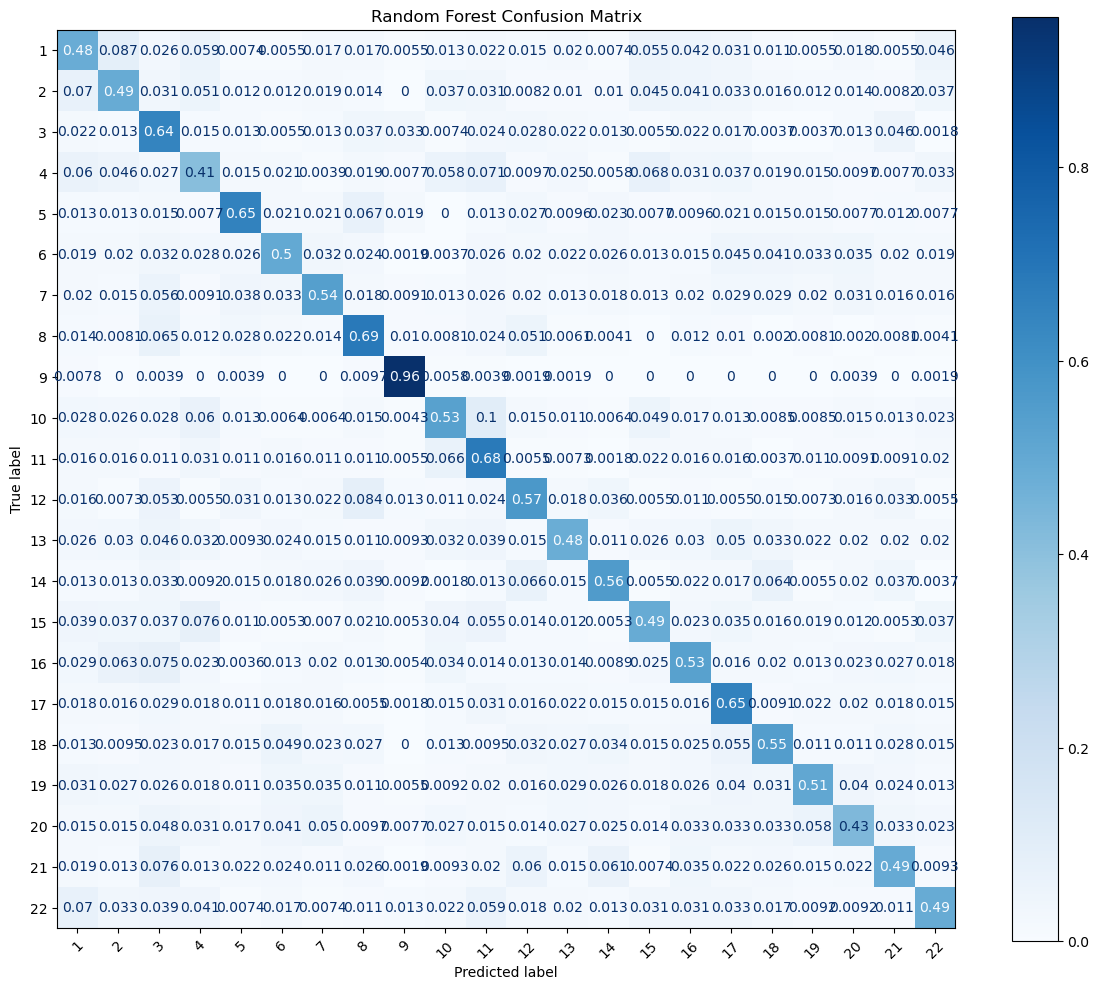

In [74]:
# Pull results
rf_model, y_test_rf, y_pred_rf = results["Random Forest"]

# Plot
class_names = [str(c) for c in sorted(np.unique(y_all))]
plot_confusion_matrix(y_test_rf, y_pred_rf, class_names, title="Random Forest Confusion Matrix")


## 4. Advanced Models

In [ ]:
X_raw = []
y_raw = []

for user_id, segments in all_user_segments.items():
    X_raw.extend(segments)                         
    y_raw.extend([user_id] * len(segments))        # label per segment

X_raw = np.array(X_raw)  # shape: (num_windows, 50, 3)
y_raw = np.array(y_raw)  # shape: (num_windows,)

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)  # shape: (n_samples,)
y_categorical = to_categorical(y_encoded)  # shape: (n_samples, num_classes)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

CNN

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

# train CNN
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

input_shape = X_train.shape[1:]  # (50, 3)
num_classes = y_categorical.shape[1]

cnn_model = create_cnn_model(input_shape, num_classes)

history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


# evaluate
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


731/731 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2426 - loss: 2.6105 - val_accuracy: 0.3826 - val_loss: 1.7985
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4349 - loss: 1.7619 - val_accuracy: 0.3755 - val_loss: 2.0283
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4777 - loss: 1.6332 - val_accuracy: 0.4971 - val_loss: 1.5669
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4959 - loss: 1.5752 - val_accuracy: 0.5342 - val_loss: 1.4540
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5043 - loss: 1.5402 - val_accuracy: 0.3819 - val_loss: 1.8823
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5235 - loss: 1.4876 - val_accuracy: 0.5088 - val_loss: 1.5045
Epoch 7/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5304 - loss: 1.4665 - val_accuracy: 0.4993 - val_loss: 1.5704
Epoch 8/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5294 - loss: 1.4568 - val_accuracy: 0.5637 - val_

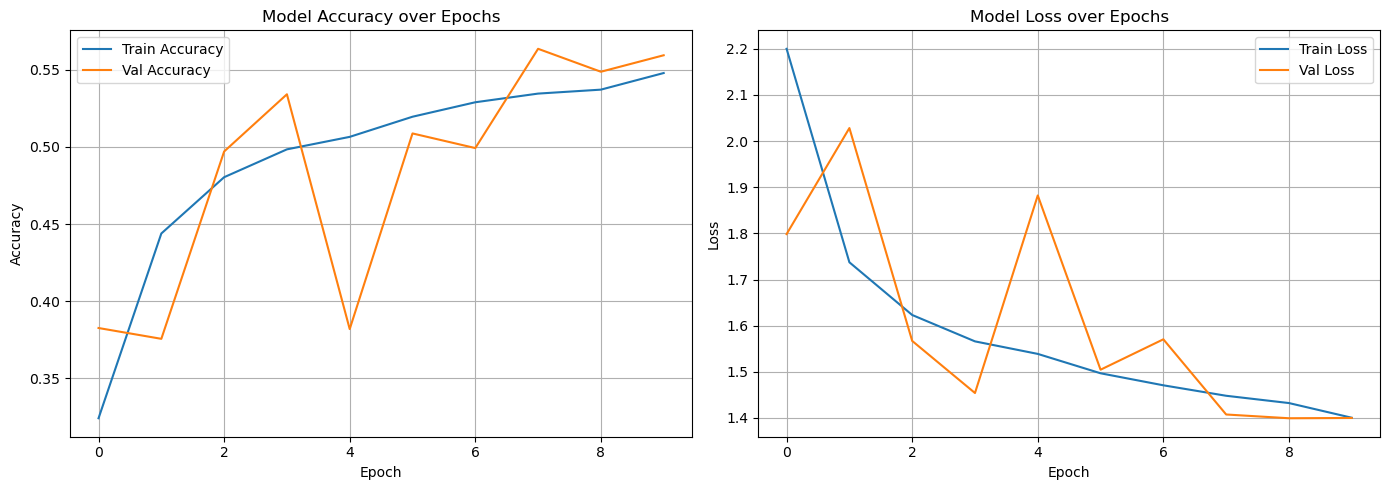

In [98]:
# plot accuracy and loss over epochs
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training & validation accuracy and loss curves.
    """
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

LSTM

Epoch 1/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.1329 - loss: 2.9248 - val_accuracy: 0.3684 - val_loss: 2.0130
Epoch 2/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.3769 - loss: 1.9553 - val_accuracy: 0.5001 - val_loss: 1.6021
Epoch 3/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4419 - loss: 1.7636 - val_accuracy: 0.4663 - val_loss: 1.6512
Epoch 4/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4756 - loss: 1.6647 - val_accuracy: 0.5541 - val_loss: 1.4815
Epoch 5/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4953 - loss: 1.6016 - val_accuracy: 0.4623 - val_loss: 1.7205
Epoch 6/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5046 - loss: 1.5725 - val_accuracy: 0.5140 - val_loss: 1.4997
Epoch 7/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5104 - loss: 1.5529 - val_accuracy: 0.4483 - val_loss: 1.7838
Epoch 8/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5246 - loss: 1.5069 - 

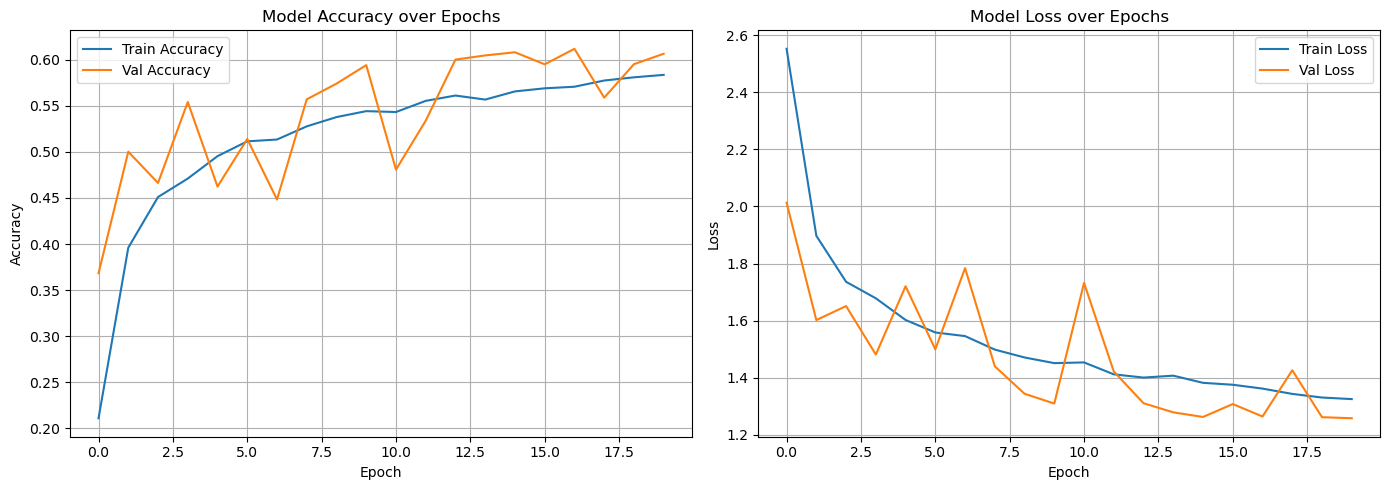

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model


# train LSTM
input_shape = X_train.shape[1:]      # (50, 3)
num_classes = y_categorical.shape[1] # 22

lstm_model = create_lstm_model(input_shape, num_classes)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    #callbacks=[early_stop]  # optional if defined before
)

# evaluate
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {accuracy:.4f}")

plot_training_history(history_lstm)  # same plot function from earlier

## 6. Evaluate

F1, recall, precision

In [104]:
# k-Fold Setup
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping

def kfold_evaluate_model(create_model_fn, X, y_categorical, y_encoded, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_scores = []
    f1_scores = []
    precisions = []
    recalls = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded), 1):
        print(f"\n🔁 Fold {fold}/{n_splits}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]

        model = create_model_fn(input_shape=X.shape[1:], num_classes=y_categorical.shape[1])

        early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=0
        )

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        report = classification_report(y_true_labels, y_pred_labels, output_dict=True, zero_division=0)
        f1 = report['weighted avg']['f1-score']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        print(f"✅ Fold {fold} Accuracy: {accuracy:.4f}")
        
        # Store all metrics
        all_scores.append(accuracy)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)

    print("\n📊 Final Results (averaged over folds):")
    print(f"Accuracy:  {np.mean(all_scores):.4f}")
    print(f"F1 Score:  {np.mean(f1_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall:    {np.mean(recalls):.4f}")
    return all_scores

cnn_scores = kfold_evaluate_model(create_cnn_model, X_raw, y_categorical, y_encoded, n_splits=5)
lstm_scores = kfold_evaluate_model(create_lstm_model, X_raw, y_categorical, y_encoded, n_splits=5)



🔁 Fold 1/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fold 1 Accuracy: 0.5434

🔁 Fold 2/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fold 2 Accuracy: 0.5374

🔁 Fold 3/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fold 3 Accuracy: 0.5330

🔁 Fold 4/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fold 4 Accuracy: 0.4981

🔁 Fold 5/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fold 5 Accuracy: 0.5453

📊 Final Results (averaged over folds):
Accuracy:  0.5314
F1 Score:  0.5299
Precision: 0.5580
Recall:    0.5314

🔁 Fold 1/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
✅ Fold 1 Accuracy: 0.5923

🔁 Fold 2/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
✅ Fold 2 Accuracy: 0.5749

🔁 Fold 3/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
✅ Fold 3 Accuracy: 0.5618

🔁 Fold 4/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
✅ Fold 4 Accuracy: 0.5773

🔁 Fold 5/5


c:\Users\atrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
✅ Fold 5 Accuracy: 0.5334

📊 Final Results (averaged over folds):
Accuracy:  0.5679
F1 Score:  0.5720
Precision: 0.6170
Recall:    0.5679
